# Zelfde experiment; eerst downsamplen

In [1]:
%reload_ext autoreload
%autoreload 2
import glob
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.io.wavfile as wv
import scipy.signal as sig
import wave

from datetime import datetime
from keras.models import Sequential, load_model
from keras.layers import Dense

from contextlib import redirect_stdout

from util import util
from util import WavFileParts
from util.logUtil import LOG, LOG_HEADER
from util.confusionMatrix import ConfusionMatrix


Using TensorFlow backend.


# Centrale parameters: targetFreq, windowLength / NFFT

In [2]:
targetFreq = 8000
windowLength = 0.032 
NFFT = 256

### globale settings

In [3]:
classes = ['music', 'voice', 'environment']

macDir = '/Volumes/SAA_DATA/datasets/'
winDir = 'E:/SAA_DATA/'
osDir = winDir
recordingDir = osDir + '/localizationRecordings'

if osDir == winDir:
    storageFolder = 'E:/SAA_DATA/storedData/'
else:
    storageFolder = '/Users/etto/Desktop/storedData/'

baseSrcDir = osDir + 'localizationFiles/20171025AllExtractionsMic4'
orgWavDirs1 = ['G428_0.0_1.4',
              'G527_0.5_1.4',
              'Studio_2.0_4.2'
              ]

orgWavDirs2 = ['G428_2.1_2.4',
              'G527_1.2_5.8',
              'Studio_3.0_2.0'
              ]

orgsG428 = ['G428_0.0_1.4','G428_2.1_2.4']
orgsG527 = ['G527_0.5_1.4','G527_1.2_5.8']
orgsStudio = ['Studio_2.0_4.2','Studio_3.0_2.0']

chunksBaseDir = 'chunks'
rooms = ['Studio', 'G428', 'G527']

### utility functies

In [4]:
def readSoundChunksDynamic(moduleString):
    chunks = importlib.import_module(moduleString).soundChunks
    wfPts = []
    for jsonString in chunks:
        wfPts.append(WavFileParts.WavFilePartFromJson(jsonString))
    return wfPts

def timeFunction(func):
    """
    Aanroep: bijv. fpc = timeFunction(lambda: getFilesPerCategory(srcDir))
    """
    startTime = datetime.now()
    print('Start: ' + startTime.strftime('%H:%M:%S') + '\n=================')

    res = func()
    
    endTime = datetime.now()
    print('\n=================\nEnd: ' + endTime.strftime('%H:%M:%S'))
    print('Time taken: '),
    print(endTime - startTime)
    print()
    
    return res
    
def storeTestData(allSpectros, allClasses, storageName, NFFT, keyName):
    filename = storageFolder + storageName + '_NFFT{:d}.hd5'.format(NFFT)
    df = pd.DataFrame(allSpectros)
    df.to_hdf(path_or_buf=filename, key='spectros_' + keyName)

    df = pd.DataFrame(allClasses)
    df.to_hdf(path_or_buf=filename, key='classes_' + keyName)

def retrieveTestData(storageName, NFFT, keyName):
    filename = storageFolder + storageName + '_NFFT{:d}.hd5'.format(NFFT)
    specDf = pd.read_hdf(path_or_buf=filename, key='spectros_' + keyName)
    classesDf = pd.read_hdf(path_or_buf=filename, key='classes_' + keyName)
    return specDf.values, classesDf.values

    

### functies tbv trainen

In [5]:
# Maakt een dictionary aan; per categorie alle files (volledig pad) uit de srcDir
# srcDir is een van de orgWavDirs, bijvoorbeeld
#    localizationFiles/20171025AllExtractionsMic4/G428_0.0_1.4
def getFilesPerCategory(srcDir):
    filesPerCategory = {}
    for catDirLong in glob.glob(srcDir + '/*'):
        catDir = catDirLong.replace('\\', '/')
        catDir = catDir.replace(srcDir + '/', '')

        filesPerCategory[catDir] = []
        for filename in glob.glob(catDirLong + '/*'):
            filename = filename.replace('\\','/')
            filesPerCategory[catDir].append(filename)
    return filesPerCategory

def getFilesPerCatFromMultipleDirs(srcDirs, srcDirsBase=''):
    filesPerCat = {}
    for dirName in srcDirs:
        srcDir = srcDirsBase + '/' + dirName
        fpcNw = getFilesPerCategory(srcDir)
        if not filesPerCat:
            filesPerCat = fpcNw
        else:
            for key in filesPerCat:
                filesPerCat[key] += fpcNw[key]
    return filesPerCat
        

In [6]:
# dowsampling functions
def getDownsampledSignal(signal, fsOrg, fsTarget):
    lpSignal = applyLowpassFilter(signal, int(fsTarget / 2), fsOrg)
    print('lowpassed')
    numSamples = int(fsTarget * 1.0 * len(lpSignal) / fsOrg)
    print('numsamples: {}'.format(numSamples))
    dsSignal = np.array(sig.resample(lpSignal, numSamples))
    print('resampled')
    return dsSignal

def applyLowpassFilter(signal, hiFrq, fs):
    b, a = sig.butter(2, 1.0 * hiFrq / fs)
    return sig.lfilter(b, a, signal)

In [7]:
filename = 'E:/SAA_DATA/localizationFiles/20171025AllExtractionsMic4/G428_2.1_2.4/music/music_4.wav'
fsTarget = 8000
fsOrg, signal = wv.read(filename)
signalDs = getDownsampledSignal(signal, fsOrg, fsTarget)


lowpassed
numsamples: 717600
resampled


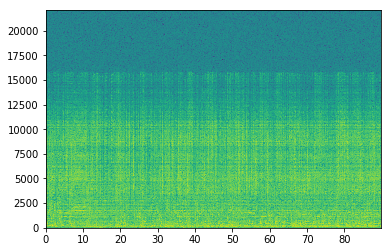

In [8]:
plt.specgram(x=signal, NFFT=2048, Fs=fsOrg)
plt.show()

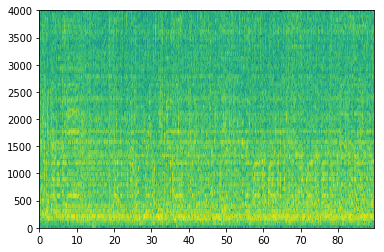

In [9]:
plt.specgram(x=signalDs, NFFT=NFFT, Fs=fsTarget)
plt.show()

In [10]:
len(signalDs) / fsTarget

89.7

In [11]:
len(signal) / fsOrg

89.7